In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Датасет MNIST


In [2]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

## Полносвязные нейронные сети
Решим сначала MNIST с помощью полносвязной нейронной сети.

In [24]:
class Identical(nn.Module):
    
    def forward(self, x):
        return x

### Простая полносвязная нейронная сеть

Создадим полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задаём лосс для обучения: кросс-энтропия.


In [34]:
activation = nn.ELU()

model = nn.Sequential(nn.Flatten(),nn.Linear(784,128), activation,nn.Linear(128,10))

In [35]:
criterion = nn.CrossEntropyLoss()    
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Цикл обучения.

In [36]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
loss_arr = []
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                optimizer.zero_grad()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  torch.sum(preds==y_batch)
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss_arr.append(loss)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.90935
Loader: valid. Accuracy: 0.926
Epoch: 2
Loader: train. Accuracy: 0.9480333333333333
Loader: valid. Accuracy: 0.9547
Epoch: 3
Loader: train. Accuracy: 0.9561666666666667
Loader: valid. Accuracy: 0.9532
Epoch: 4
Loader: train. Accuracy: 0.96165
Loader: valid. Accuracy: 0.9441
Epoch: 5
Loader: train. Accuracy: 0.96465
Loader: valid. Accuracy: 0.9642
Epoch: 6
Loader: train. Accuracy: 0.9681333333333333
Loader: valid. Accuracy: 0.9552
Epoch: 7
Loader: train. Accuracy: 0.9701
Loader: valid. Accuracy: 0.9622
Epoch: 8
Loader: train. Accuracy: 0.9711833333333333
Loader: valid. Accuracy: 0.9637
Epoch: 9
Loader: train. Accuracy: 0.9746333333333334
Loader: valid. Accuracy: 0.9553
Epoch: 10
Loader: train. Accuracy: 0.9747166666666667
Loader: valid. Accuracy: 0.9692


### Протестируем разные функции активации.
Попробуем разные функции активации. Для каждой функции активации считаем массив validation accuracy

In [37]:
elu_accuracy = accuracy["valid"]

In [29]:
def test_activation_function(activation):
    if isinstance(activation, type):
        activation = activation()  
    model = nn.Sequential(nn.Flatten(),nn.Linear(784,128), activation,nn.Linear(128,10))
    criterion = nn.CrossEntropyLoss()    
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    loss_arr = []
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    optimizer.zero_grad()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct =  torch.sum(preds==y_batch)
                all =  len(y_batch) 
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss_arr.append(loss)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]
       

In [33]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())

Epoch: 1
Loader: train. Accuracy: 0.85905
Loader: valid. Accuracy: 0.8435
Epoch: 2
Loader: train. Accuracy: 0.88535
Loader: valid. Accuracy: 0.9022
Epoch: 3
Loader: train. Accuracy: 0.8913833333333333
Loader: valid. Accuracy: 0.9129
Epoch: 4
Loader: train. Accuracy: 0.8935166666666666
Loader: valid. Accuracy: 0.9063
Epoch: 5
Loader: train. Accuracy: 0.8970833333333333
Loader: valid. Accuracy: 0.8999
Epoch: 6
Loader: train. Accuracy: 0.8981333333333333
Loader: valid. Accuracy: 0.8995
Epoch: 7
Loader: train. Accuracy: 0.8986
Loader: valid. Accuracy: 0.8903
Epoch: 8
Loader: train. Accuracy: 0.9000166666666667
Loader: valid. Accuracy: 0.8961
Epoch: 9
Loader: train. Accuracy: 0.9006333333333333
Loader: valid. Accuracy: 0.8939
Epoch: 10
Loader: train. Accuracy: 0.9017333333333334
Loader: valid. Accuracy: 0.9079
Epoch: 1
Loader: train. Accuracy: 0.9037666666666667
Loader: valid. Accuracy: 0.941
Epoch: 2
Loader: train. Accuracy: 0.9429666666666666
Loader: valid. Accuracy: 0.9603
Epoch: 3
Loade

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

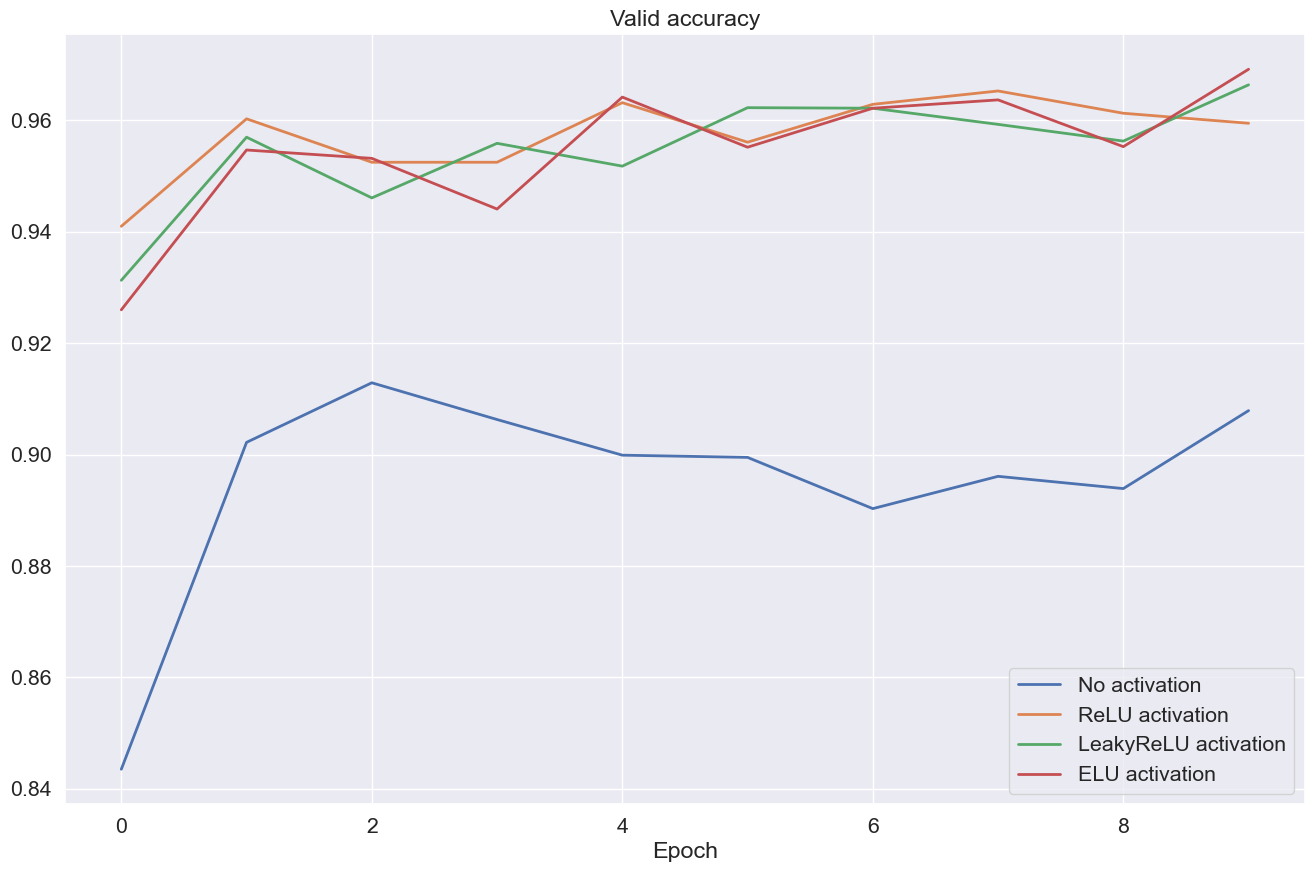

In [38]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

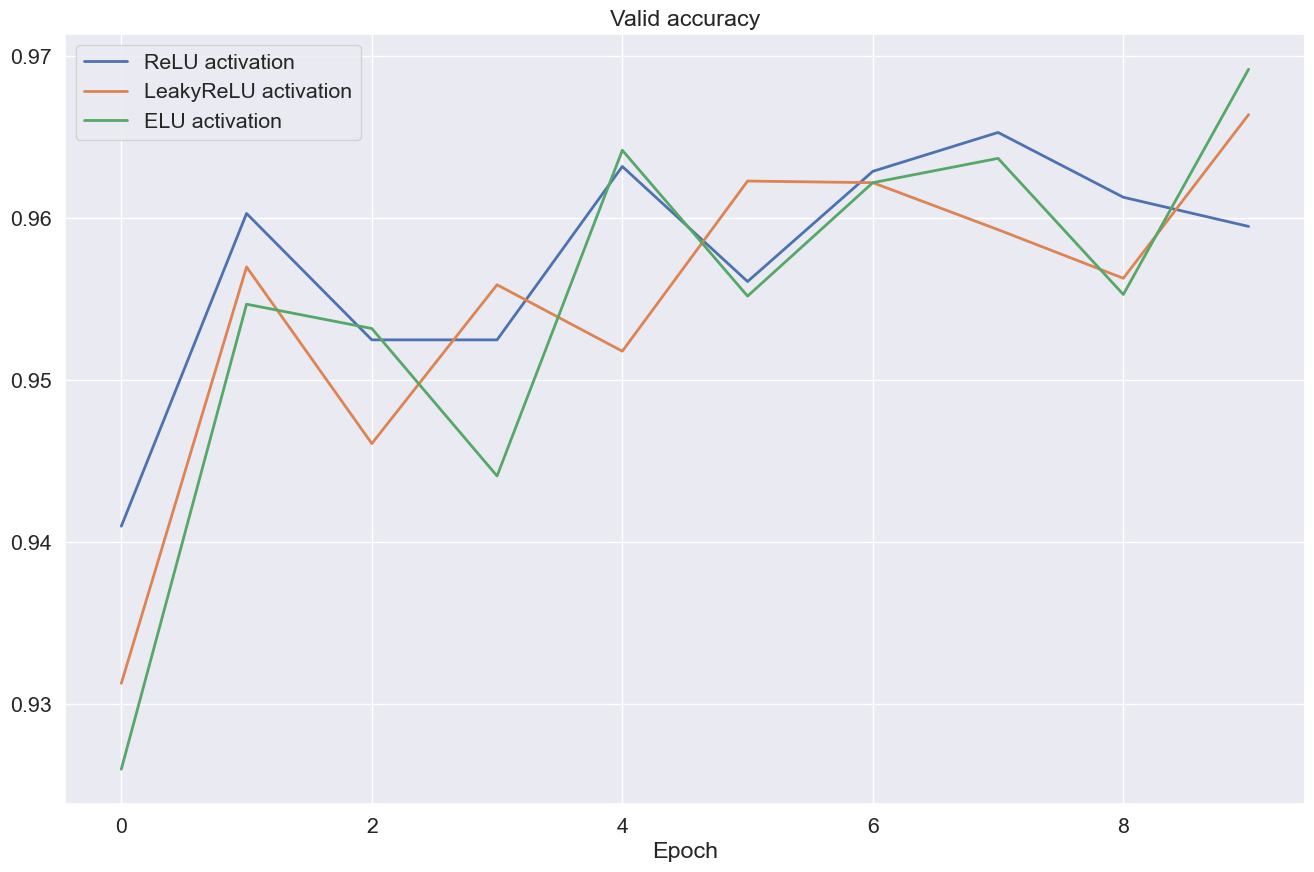

In [39]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

## Сверточные нейронные сети

### Реализуем теперь LeNet

Используем модульную структуру. Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [103]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6,16,3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(25*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [104]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Обучение CNN


In [105]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
loss_arr = []
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                optimizer.zero_grad()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  torch.sum(preds==y_batch)
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss_arr.append(loss)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9517
Loader: valid. Accuracy: 0.9765
Epoch: 2
Loader: train. Accuracy: 0.98245
Loader: valid. Accuracy: 0.9824
Epoch: 3
Loader: train. Accuracy: 0.9863833333333333
Loader: valid. Accuracy: 0.9845
Epoch: 4
Loader: train. Accuracy: 0.9887166666666667
Loader: valid. Accuracy: 0.9882
Epoch: 5
Loader: train. Accuracy: 0.99025
Loader: valid. Accuracy: 0.9849
Epoch: 6
Loader: train. Accuracy: 0.99145
Loader: valid. Accuracy: 0.9849
Epoch: 7
Loader: train. Accuracy: 0.9929166666666667
Loader: valid. Accuracy: 0.9858
Epoch: 8
Loader: train. Accuracy: 0.9930666666666667
Loader: valid. Accuracy: 0.9884
Epoch: 9
Loader: train. Accuracy: 0.9936333333333334
Loader: valid. Accuracy: 0.9864
Epoch: 10
Loader: train. Accuracy: 0.99395
Loader: valid. Accuracy: 0.9885


In [107]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

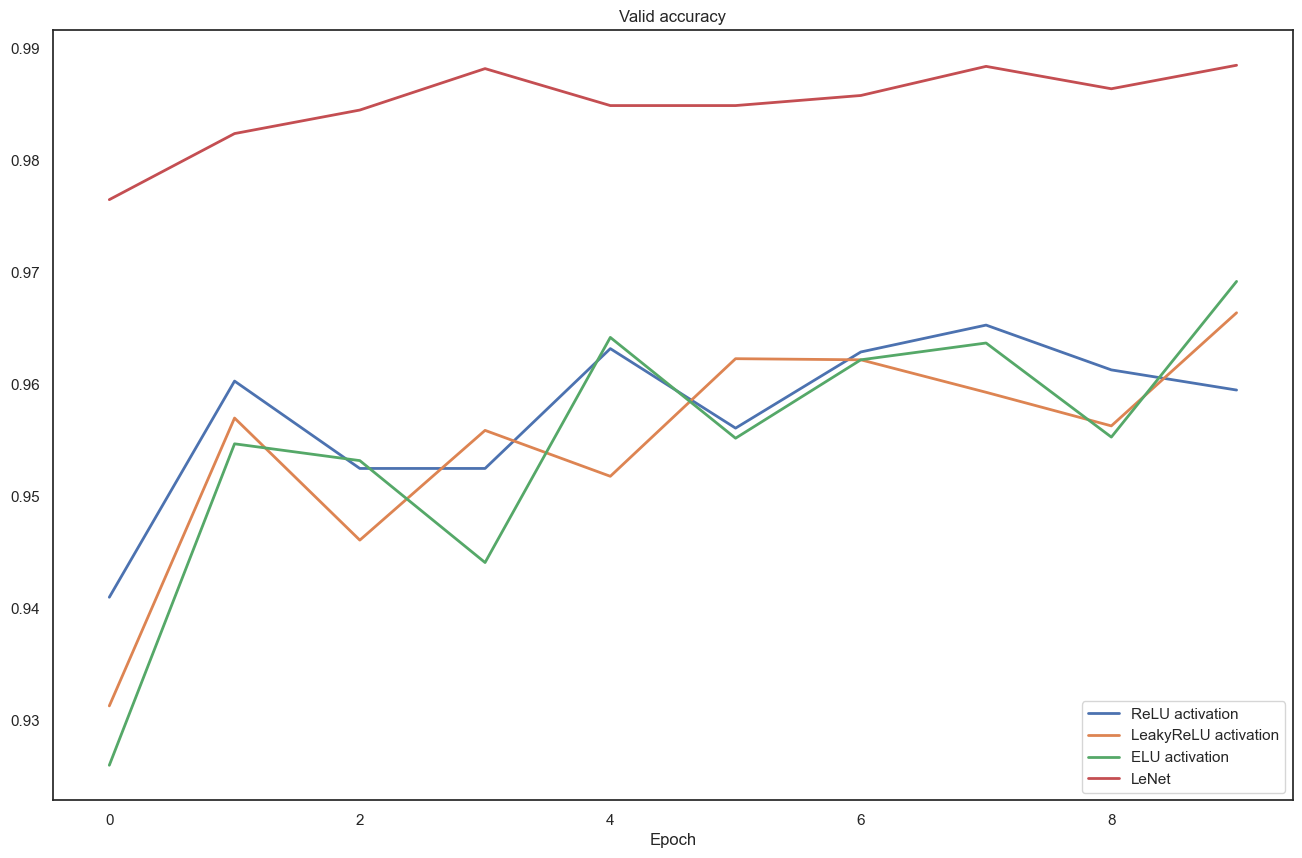

In [108]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

В итоге, получаем, что с помощью свёрточных нейронных сетей получается добиться лучших результатов по сравнению с полносвязными сетями (без свёрточных слоёв). 